Untuk menyimpan dataset sebagai database SQL di perlukan memasang pandas sqlalchemy pymysql

Untuk melakukan analisis kependudukan di Provinsi Jawa Barat di perlukan beberapa library

In [2]:
# Data processing
import pandas as pd
import numpy as np
import re
import math
import textwrap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import plotly.express as px
import plotly.graph_objects as go

# Annotation & Styling
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from matplotlib.patches import FancyArrowPatch
from matplotlib.font_manager import FontProperties
from highlight_text import fig_text, ax_text

# Animation
from matplotlib.animation import FuncAnimation
from PIL import Image, ImageSequence

# Database
from sqlalchemy import create_engine

# Statistics
from scipy.stats import kendalltau


Memasukan dataset yang akan digunakan ke dalam database SQL 

> 💡 **Catatan:** Data bersumber dari data.jabarprov.go.id dan file CSV sudah tercantum di laman GitHub

In [3]:
#Membuat koneksi database yang di pakai untuk query
engine = create_engine("mysql+pymysql://root:(rootuser)/portofolio")

#Membaca file CSV dan menyimpan hasil bacaan ke dalam variabel df... dalam bentuk DataFrame 
df_kasus_penyakit = pd.read_csv(".../kasus penyakit.csv")
df_jumlah_kematian = pd.read_csv(".../jumlah kematian.csv")
df_daftar_rs = pd.read_csv(".../daftar rumah sakit.csv")
df_kel_pekerjaan = pd.read_csv(".../kelompok pekerjaan.csv")
df_jum_penduduk = pd.read_csv(".../jumlah penduduk.csv")
df_ind_bpjs = pd.read_csv(".../indeks pemanfaatan bpjs.csv")
df_jum_pen_miskin = pd.read_csv(".../jumlah penduduk miskin.csv")
df_jum_warga_bpjs = pd.read_csv(".../jumlah warga terdaftar sbg bpjs.csv")
df_per_pend_miskin = pd.read_csv(".../persentase penduduk miskin.csv")
df_jum_fasilitas = pd.read_csv(".../jum_fasilitas.csv")

#Menyimpan Data Frame ke database dengan nama tabel masing masing dan mengoneksikan database yang sudak di buat 
df_kasus_penyakit.to_sql("kasus_penyakit", con=engine, if_exists="replace", index=False)
df_jumlah_kematian.to_sql("jum_kematian", con=engine, if_exists="replace", index=False)
df_daftar_rs.to_sql("daftar_rs", con=engine, if_exists="replace", index=False)
df_kel_pekerjaan.to_sql("kel_pekerjaan", con=engine, if_exists="replace", index=False)
df_jum_penduduk.to_sql("jum_penduduk", con=engine, if_exists="replace", index=False)
df_ind_bpjs.to_sql("ind_bpjs", con=engine, if_exists="replace", index=False)
df_jum_pen_miskin.to_sql("jum_pen_miskin", con=engine, if_exists="replace", index=False)
df_jum_warga_bpjs.to_sql("jum_warga_bpjs", con=engine, if_exists="replace", index=False)
df_per_pend_miskin.to_sql("per_pend_miskin", con=engine, if_exists="replace", index=False)
df_jum_fasilitas.to_sql("jum_fasilitas", con=engine, if_exists="replace", index=False)

#Print tanda running program selesai
print("Berhasil upload ke MySQL!")

Berhasil upload ke MySQL!


In [4]:
#Memperlihatkan daftar tabel yang sudah dibuat
query = "SHOW TABLES;"
tables_df = pd.read_sql(query, engine)
print(tables_df)

  Tables_in_porto_adinda
0              daftar_rs
1               ind_bpjs
2          jum_fasilitas
3           jum_kematian
4         jum_pen_miskin
5           jum_penduduk
6         jum_warga_bpjs
7         kasus_penyakit
8          kel_pekerjaan
9        per_pend_miskin


Mengolah dataset kependudukan Jawa Barat

In [5]:
#Menunjukan tabel Jumlah Penduduk 5 Baris pertama dari varibel engine yang telah di buat untuk koneksi SQL 
pd.read_sql("SELECT * FROM jum_penduduk LIMIT 5;", engine)

,id,kode_provinsi,nama_provinsi,kode_kabupaten_kota,nama_kabupaten_kota,jenis_kelamin,jumlah_penduduk,satuan,tahun
0,1,32,JAWA BARAT,3201,KABUPATEN BOGOR,LAKI-LAKI,1930902,JIWA,2013
1,2,32,JAWA BARAT,3201,KABUPATEN BOGOR,PEREMPUAN,1826962,JIWA,2013
2,3,32,JAWA BARAT,3202,KABUPATEN SUKABUMI,LAKI-LAKI,1258939,JIWA,2013
3,4,32,JAWA BARAT,3202,KABUPATEN SUKABUMI,PEREMPUAN,1171101,JIWA,2013
4,5,32,JAWA BARAT,3203,KABUPATEN CIANJUR,LAKI-LAKI,1154944,JIWA,2013


In [6]:
#Membuat query dari dataset Jumlah Penduduk Pertahunnya
jum_penduduk_pertahun ="""
        SELECT 
            tahun,
            SUM(jumlah_penduduk) AS total
        FROM jum_penduduk
        GROUP BY tahun
        ORDER BY tahun
        """

#Memasukan hasil query ke dataFrame
df_jum_penduduk_pertahun = pd.read_sql(jum_penduduk_pertahun, engine)

#Mencetak 5 baris pertama dari dataFrame yang sudah dibuat
print(df_jum_penduduk_pertahun.head())

   tahun       total
0   2013  42223484.0
1   2014  42430424.0
2   2015  43195688.0
3   2016  43740159.0
4   2017  44362139.0


Line chart dapat digunakan untuk melihat perubahan jumlah penduduk dari tahun ke tahun.

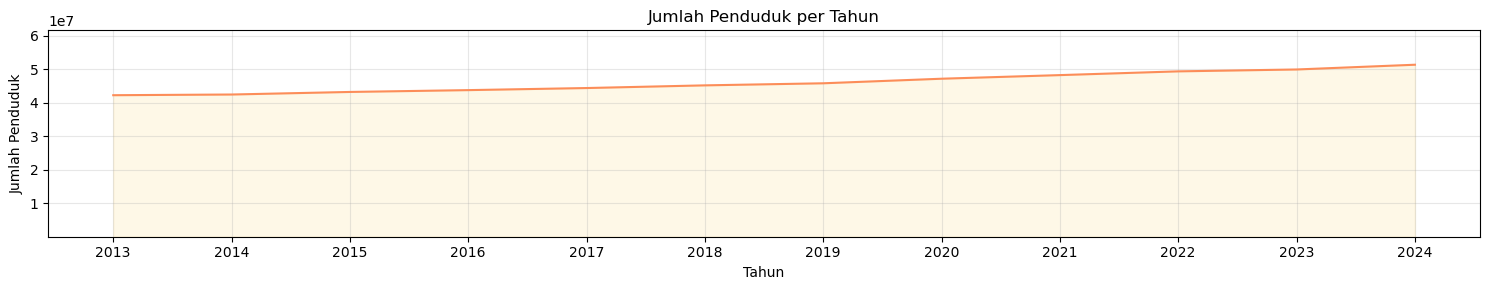

In [7]:
#Menggunakan tahun untuk menyortir data
df_jum_penduduk_pertahun = df_jum_penduduk_pertahun.sort_values("tahun")

# Konversi jadi NumPy array
tahun = df_jum_penduduk_pertahun['tahun'].values
total = df_jum_penduduk_pertahun['total'].values

#Format ukuran gambar grafik
plt.figure(figsize=(15,3))

# Garis utama
sns.lineplot(x=tahun, y=total, color='#fc8d59', linewidth=1.5)

# Area di bawah garis
plt.fill_between(tahun, total, color="#fee08b", alpha=0.2)

# Menampilkan semua tahun
plt.xticks(ticks=tahun, labels=tahun)

#Format title grafik
plt.ylim(6, total.max() * 1.2)
plt.title("Jumlah Penduduk per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Penduduk")
plt.grid(alpha=0.3)
plt.tight_layout()


#Menyimpan gambar
#plt.savefig(r'...\Jumlah Penduduk Pertahun.png')
#--Hilangkan tagar untuk menjalankan program

#Memperlihatkan grafik
plt.show()

Membuat Interactive Chart

In [9]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_jum_penduduk_pertahun['tahun'].values, # x-axis
    y=df_jum_penduduk_pertahun['total'].values, # y-axis
    mode='lines', # Connect data points with lines
    name='Line' # Name in the legend
))

# Add and change title style
fig.update_layout(
    title='<b>Jumlah Penduduk Jawa Barat Tahun 2013-2024',
    title_font=dict(size=14),
    title_x=0.05,  # Title aligned with grid
    title_y=0.85,  # Title positioned near the top vertically
    
)
#fig.write_html( r'...\Jumlah Penduduk Pertahun.html', include_plotlyjs='cdn',  # load Plotly JS dari CDN, bukan disisipkan penuhfull_html=False  # simpan hanya div plot, bukan seluruh HTML page )
fig.show()

Untuk melihat pertumbuhan penduduk dapat digunakan persentase perubahan antar tahun

In [13]:
#Membuat kolom baru bernama 'growth'
#Kolom di hasilkan dari persentase perubahan antar tahun yang di ubah mejadi persen dari desimal
df_jum_penduduk_pertahun['growth'] = df_jum_penduduk_pertahun['total'].pct_change() * 100

#Menghitung rata-rata persentase perubaan
rata_rata=df_jum_penduduk_pertahun['growth'].mean()

#Memperlihatkan hasil query Jumlah Penduduk setelah ditambahkan kolom 'growth'
print (df_jum_penduduk_pertahun)

#Memperlihatkan hasil hitung rata-rata perubahan
print('Rata-rata pertumbuhan penduduk=',rata_rata)

    tahun       total    growth
0    2013  42223484.0       NaN
1    2014  42430424.0  0.490106
2    2015  43195688.0  1.803574
3    2016  43740159.0  1.260475
4    2017  44362139.0  1.421988
5    2018  45161325.0  1.801505
6    2019  45779597.0  1.369030
7    2020  47142623.0  2.977366
8    2021  48220094.0  2.285556
9    2022  49339670.0  2.321804
10   2023  49899992.0  1.135642
11   2024  51316378.0  2.838449
Rata-rata pertumbuhan penduduk= 1.7914086504905062


Gunakan Line Chart untuk meliat pola pertumbuhan penduduk dari tahun ke tahun`

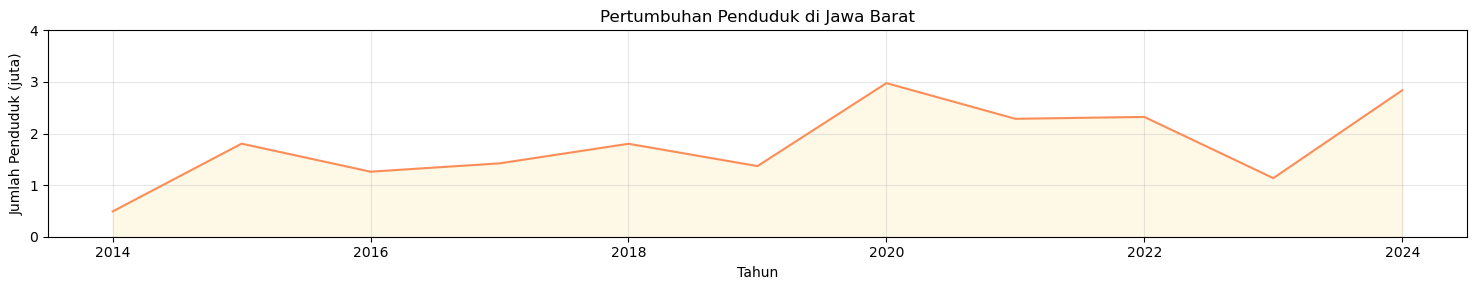

In [14]:

#Menggunakan tahun untuk menyortir data
df_jum_penduduk_pertahun = df_jum_penduduk_pertahun.sort_values("tahun")

#Konversi menjadi NumPy Array
tahun = df_jum_penduduk_pertahun['tahun'].values
total = df_jum_penduduk_pertahun['growth'].values

#Format ukuran gambar grafik
plt.figure(figsize=(15,3))

# Garis utama
sns.lineplot(x=tahun, y=total, color='#fc8d59', linewidth=1.5)

# Area di bawah garis
plt.fill_between(tahun, total, color="#fee08b", alpha=0.2)

# Menampilkan semua tahun
#plt.xticks(ticks=tahun, labels=tahun)

#Karena terdapat NaN pada kolom growth
# Mengatur batas y-axis dengan validasi isi data
if total.size > 0 and not np.isnan(total).all() and np.isfinite(total).all():
    plt.ylim(3, total.max() * 1.2)
else:
    plt.ylim(0, 4)  # fallback default jika data tidak valid

# Label dan judul
plt.title("Pertumbuhan Penduduk di Jawa Barat")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Penduduk (juta)")
plt.grid(alpha=0.3)
plt.tight_layout()

#Menyimpan gambar
#plt.savefig(r'C:\Users\Dinda.D.L\Downloads\Downloads\data.jabarprov.go.id\Jumlah Penduduk Pertahun.png')
#--Hilangkan tagar untuk menjalankan program

#Memperlihatkan grafik
plt.show()

Interactive Chart

In [15]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_jum_penduduk_pertahun['tahun'].values, # x-axis
    y=df_jum_penduduk_pertahun['growth'].values, # y-axis
    mode='lines', # Connect data points with lines
    name='Line' # Name in the legend
))

# Add and change title style
fig.update_layout(
    title='<b>Pertumbuhan Penduduk di Jawa Barat Tahun 2013-2024',
    title_font=dict(size=14),
                    #color='blue',
                    #family='Arial'),
    title_x=0.05,  # Title aligned with grid
    title_y=0.85,  # Title positioned near the top vertically
    
)
#fig.write_html( r'...\Pertumbuhan oenduduk di jawa barat.html', include_plotlyjs='cdn',  # load Plotly JS dari CDN, bukan disisipkan penuhfull_html=False  # simpan hanya div plot, bukan seluruh HTML page 
            #  )

Dataset kependudukan Jawa Barat juga dapat digunakan untuk melihat tingkat kesenjangan jenis kelamin dari jumlah penduduk setiap jenis kelamin. Tahun yang digunakan untuk melihat perbandingan jenis kelamin adalah tahun terakhir pada dataset.

In [16]:
#Query tabel Jumlah Penduduk untuk jenis kelamin perempuan pada tahun 2024
jum_penduduk_perempuan="""
    SELECT jenis_kelamin,
        SUM(jumlah_penduduk) AS total
    FROM jum_penduduk
    WHERE tahun='2024' AND jenis_kelamin='PEREMPUAN'
    GROUP BY jenis_kelamin
    """
#Memasukan hasil query ke dalam dataFrame
df_jum_penduduk_perempuan= pd.read_sql(jum_penduduk_perempuan, engine)

#------
#Query tabel Jumlah Penduduk untuk jenis kelamin laki-laki pada tahun 2024
jum_penduduk_laki="""
    SELECT jenis_kelamin,
        SUM(jumlah_penduduk) AS total
    FROM jum_penduduk
    WHERE tahun='2024' AND jenis_kelamin='LAKI-LAKI'
    GROUP BY jenis_kelamin
    """
#Memasukan hasil query ke dalam dataFrame
df_jum_penduduk_laki= pd.read_sql(jum_penduduk_laki, engine)

# Menampilkan hasil Jumlah Penduduk perjenis kelamin dengan mengamil nilai pada kolom total 
print('Jumlah Penduduk Perempuan =',df_jum_penduduk_perempuan['total'][0])
print('Jumlah Penduduk Laki-laki =',df_jum_penduduk_laki['total'][0])

Jumlah Penduduk Perempuan = 25318584.0
Jumlah Penduduk Laki-laki = 25997794.0


Untuk melihat tingkat kesenjangan jenis kelamin dapat dilihat dengan membuat perbandingan antara jumlah penduduk perempuan dengan laki-laki

In [17]:
#Membagi antara jumlah penduduk perempuan dan laki-laki dari nilai pada kolom total
rasio_penduduk= df_jum_penduduk_laki['total'] / df_jum_penduduk_perempuan['total']

#Menampilkan hasil hitung rasio
print('Rasio Kependudukan= 1:',rasio_penduduk[0])

Rasio Kependudukan= 1: 1.0268265397464567


>Dapat diartikan bahwa rasio jenis kelamin di Jawa Barat tercatat sebanyak 102 laki-laki untuk setiap 100 perempuan.

Membuat query jumlah penduduk perdaerah untuk melihat daerah dengan populasi penduduk tertinggi di Jawa Barat

In [18]:
#Query jumlah penduduk perdaerah dengan menjumlah dengan menyortir berdasarkan total penduduk tertinggi
penduduk_terbanyak = """
        SELECT 
        nama_kabupaten_kota,
        SUM(jumlah_penduduk) AS total_penduduk
        FROM jum_penduduk
        WHERE tahun='2024'
        GROUP BY nama_kabupaten_kota
        ORDER BY total_penduduk DESC"""

#Memasukan hasil query ke dalam dataFrame
df_penduduk_terbanyak= pd.read_sql(penduduk_terbanyak, engine)

# Menampilkan 5 baris pertama
print(df_penduduk_terbanyak.head())

  nama_kabupaten_kota  total_penduduk
0     KABUPATEN BOGOR       5809790.0
1   KABUPATEN BANDUNG       3839721.0
2    KABUPATEN BEKASI       3387601.0
3  KABUPATEN SUKABUMI       2868943.0
4     KABUPATEN GARUT       2851877.0


Agar pesebaran penduduk Jawa Barat perdaerah dapat di lihat dengan mudah, dapat digunakan Bart Chart Horizontal

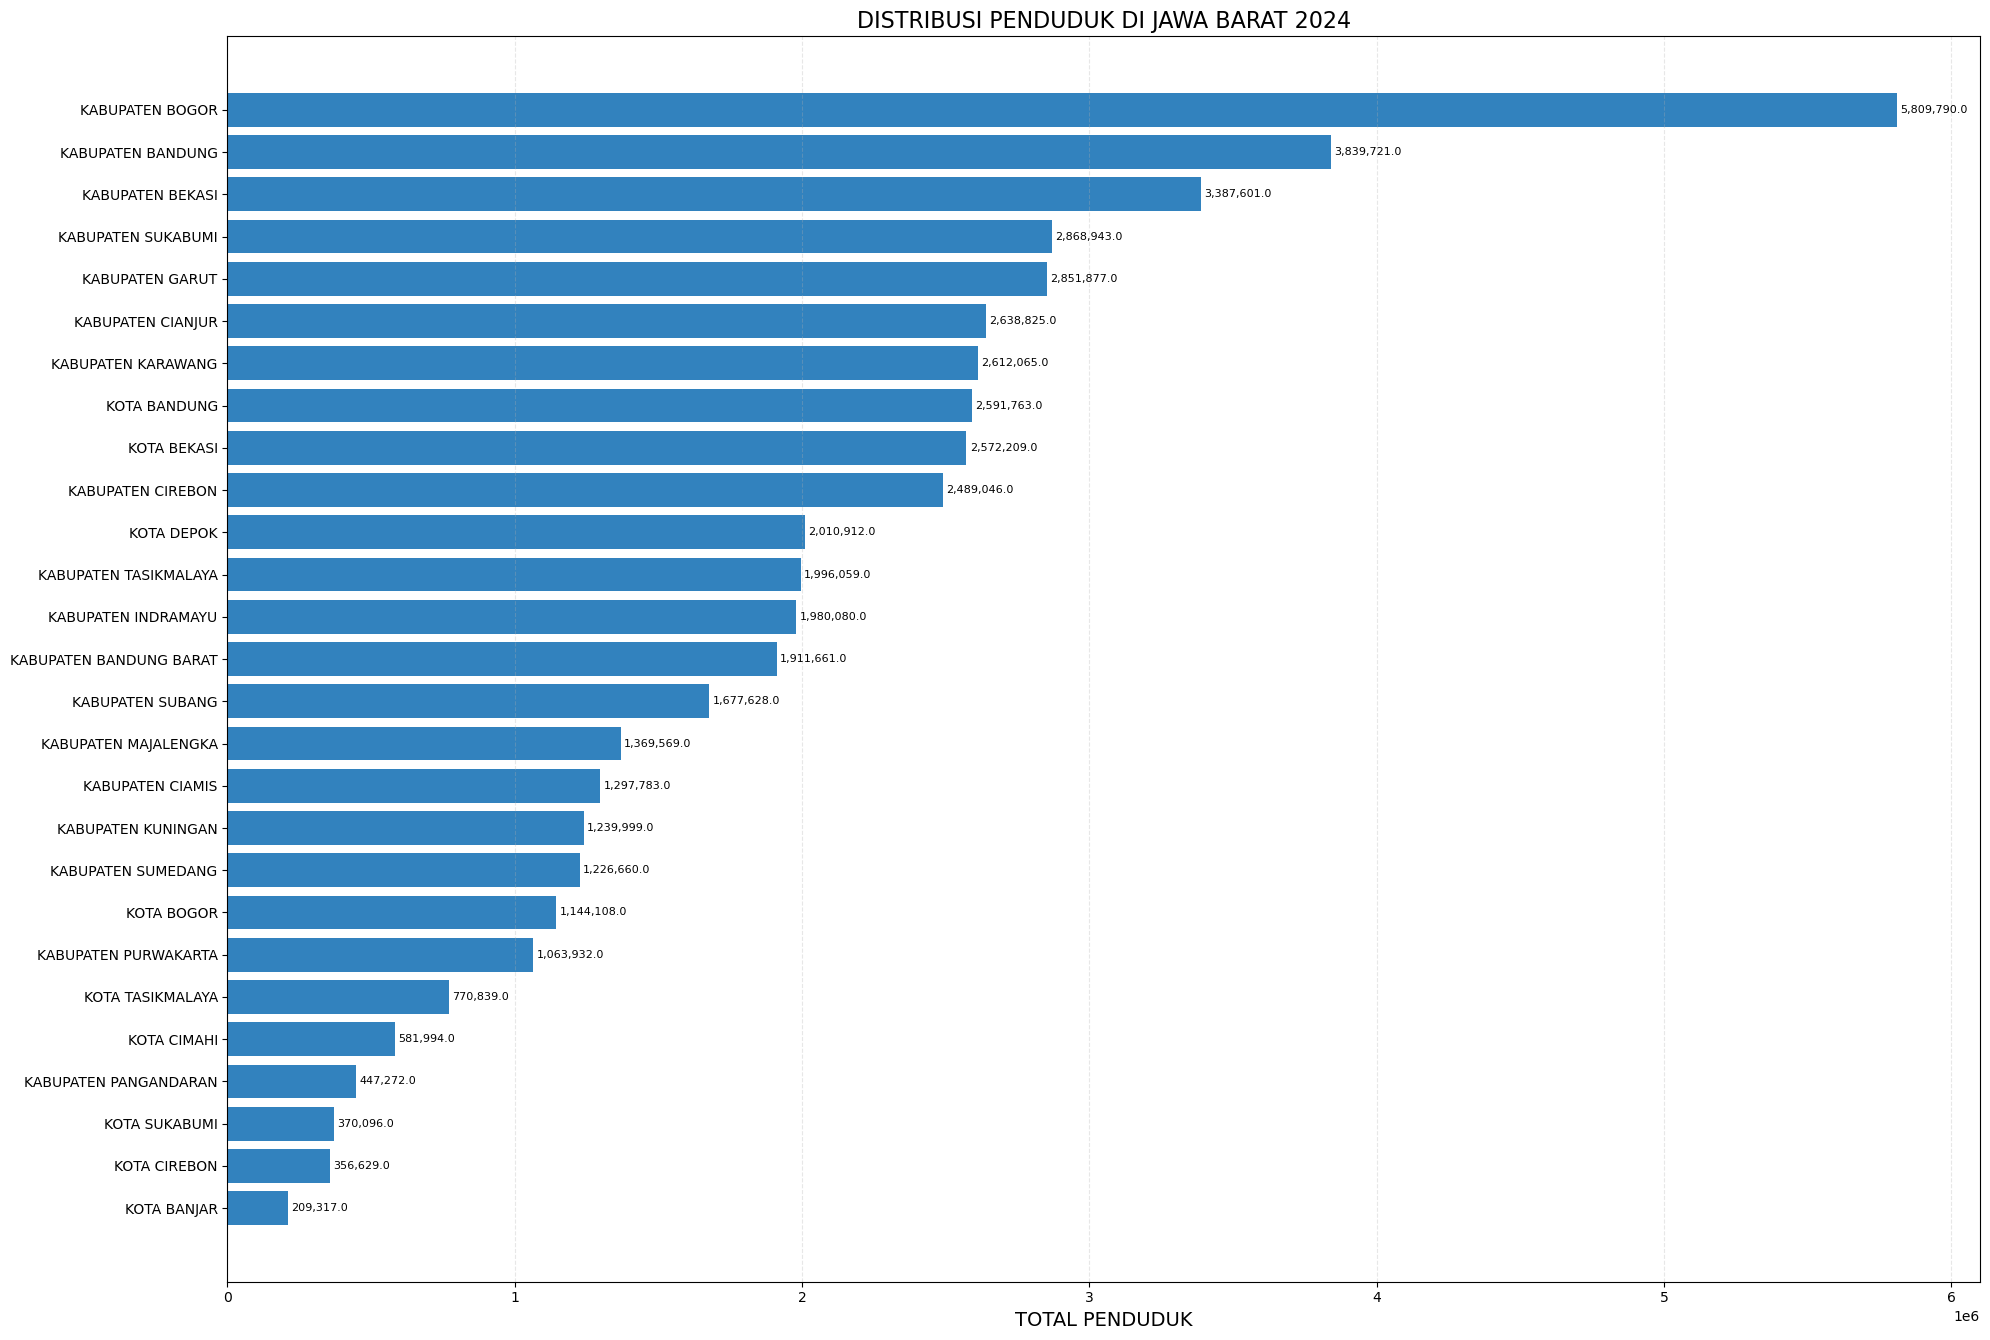

In [19]:
# Plot grafik dengan
fig, ax = plt.subplots(figsize=(20, 0.5 * len(df_penduduk_terbanyak)))  # Tinggi menyesuaikan jumlah baris

#Menentukan variabel x dan y dari dataFrame yang sudah di buat
bars = ax.barh(df_penduduk_terbanyak['nama_kabupaten_kota'], 
               df_penduduk_terbanyak['total_penduduk'], 
               color='#3282be')

#Mengatur label angka pada bar chart
for i, v in enumerate(df_penduduk_terbanyak['total_penduduk']):
    ax.text(v + 0.002 * df_penduduk_terbanyak['total_penduduk'].max(), i, f"{v:,}", va='center', fontsize=8) #Mengatur jarak label angka dari bar chart

#Format label dan judul
ax.set_xlabel("TOTAL PENDUDUK",fontsize=14)
ax.set_title("DISTRIBUSI PENDUDUK DI JAWA BARAT 2024", fontsize=16)
ax.invert_yaxis()  # Agar yang terbesar di atas --- dapat juga mengurutkan data tahun dari dataFrame value
ax.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

#Menyimpan hasil grafik
plt.savefig(
    r'...\sebaran penduduk perkabupaten.png',
    dpi=300, bbox_inches='tight'
)
#--Hilangkan tagar untuk menjalankan program

#Memperlihatkan hasil plot
plt.show()

Mengolah dataset kelompok pekerjaan

In [20]:
#Memunculkan tabel yang akan digunakan (5 baris pertama)
pd.read_sql("SELECT * FROM KEL_PEKERJAAN LIMIT 5;", engine)

,id,kode_provinsi,nama_provinsi,kelompok_pekerjaan,jenis_kelamin,jumlah_penduduk,satuan,tahun
0,1,32,JAWA BARAT,TIDAK/BELUM BEKERJA,LAKI-LAKI,5789236,JIWA,2015
1,2,32,JAWA BARAT,TIDAK/BELUM BEKERJA,PEREMPUAN,5110515,JIWA,2015
2,3,32,JAWA BARAT,MENGURUS RUMAH TANGGA,LAKI-LAKI,438,JIWA,2015
3,4,32,JAWA BARAT,MENGURUS RUMAH TANGGA,PEREMPUAN,9832208,JIWA,2015
4,5,32,JAWA BARAT,PELAJAR/MAHASISWA,LAKI-LAKI,3904150,JIWA,2015


Membuat query jumlah penduduk dari kelompok pekerjaan yang tercatat untuk selanjutnya di olah menjadi tabel pivot untuk kemudian di jadikan heatmap agar visual pesebaran kelompok pekerjaan di lihat dan diinterpretasikan dengan mudah. 

In [21]:
#Query dibuat dengan mengelompokan tahun dan kelompok pekerjaan
tahun_kel_kerjaan = """
        SELECT 
        tahun,kelompok_pekerjaan,
        SUM(jumlah_penduduk) AS total
        FROM kel_pekerjaan
        
        GROUP BY tahun,kelompok_pekerjaan
        ORDER BY tahun DESC"""

#Memasukan hasil query ke dalam dataFram
df_tahun_kel_kerjaan= pd.read_sql(tahun_kel_kerjaan, engine)

# Tampilkan 5 baris pertama hasi dataFrame
print(df_tahun_kel_kerjaan.head())

   tahun         kelompok_pekerjaan       total
0   2023      AGAMA DAN KEPERCAYAAN     16897.0
1   2023  APARATUR / PEJABAR NEGARA    748292.0
2   2023      BELUM / TIDAK BEKERJA  11654686.0
3   2023                    LAINNYA  12335091.0
4   2023                    NELAYAN     70400.0


In [22]:
#Membuat tabel pivot dari dataFrame yang sudah di buat 
pivot_df = df_tahun_kel_kerjaan.pivot_table(
    index='kelompok_pekerjaan',   # Ini jadi sumbu Y (baris)
    columns='tahun',              # Ini jadi sumbu X (kolom)
    values='total',               # Nilai yang ditampilkan
    aggfunc='sum'                 # Kalau ada duplikat, dijumlahkan
)

# Mengubah NaN menjadi 0
pivot_df=pivot_df.fillna(0)

#Menampilkan hasil pivot
print(pivot_df)

tahun                                          2015        2016        2017  \
kelompok_pekerjaan                                                            
AGAMA DAN KEPERCAYAAN                           0.0         0.0         0.0   
APARATUR / PEJABAR NEGARA                       0.0         0.0         0.0   
APARATUR/PEJABAT NEGARA                         0.0         0.0         0.0   
BELUM / TIDAK BEKERJA                           0.0         0.0         0.0   
BIDANG PENDIDIKAN DAN KESEHATAN            262757.0    292104.0    306280.0   
BURUH/TUKANG/INDUSTRI/KONSTRUKSI          3283208.0   3546826.0   3635013.0   
KARYAWAN                                  3813957.0   4168542.0   4229824.0   
KELOMPOK PROFESI                           857007.0    857177.0    847001.0   
LAINNYA                                    122865.0     70270.0    105835.0   
MENGURUS RUMAH TANGGA                     9832646.0  10435965.0  10645675.0   
NELAYAN                                         0.0 

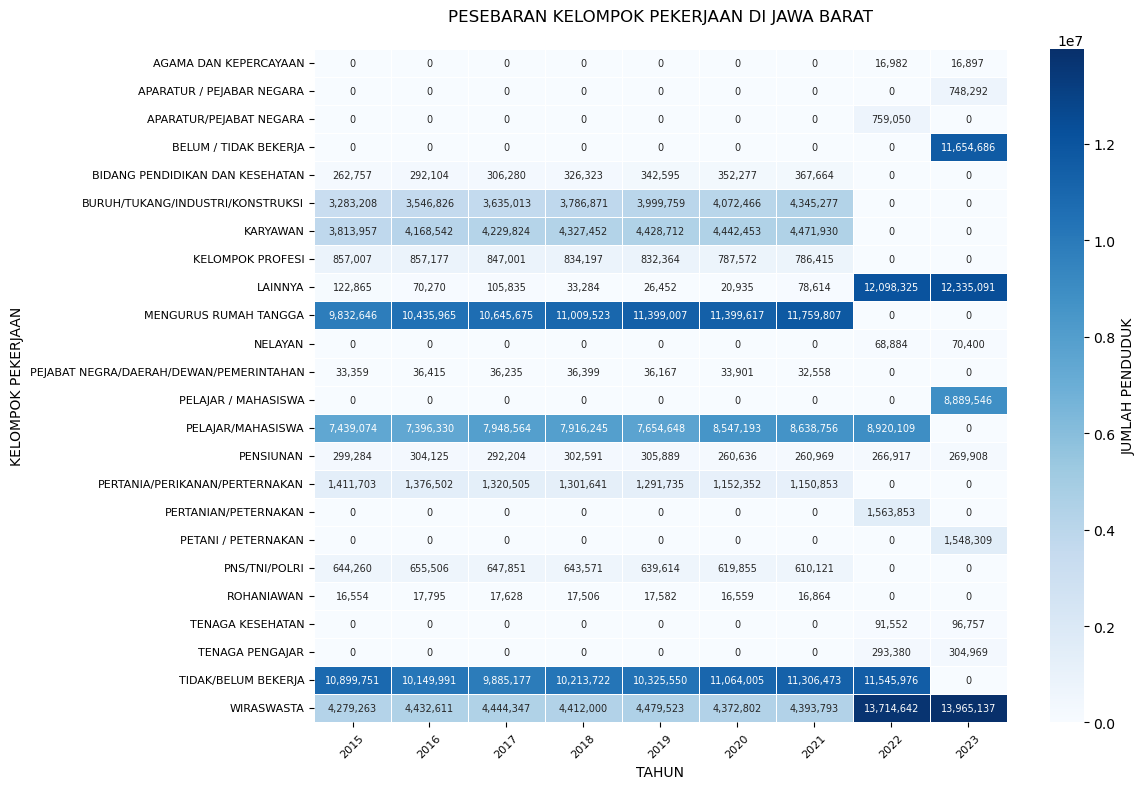

In [23]:
#Heatmap menggunakan library seaborn dan matplotlib
#Mengatur besar gambar yang akan di buat
plt.figure(figsize=(12, 8))

#Mmebuat heatmap
sns.heatmap(pivot_df, #Mengambil data dari tabel pivot 
            annot=True, #Menampilkan angka pada data
            fmt=",.0f", #Mengatur format koma dan titik angka
            cmap="Blues", #Format set warna
            linewidths=.5, #Format besar line
            cbar_kws={'label': 'JUMLAH PENDUDUK'}, #Title bar warna
            annot_kws={"size": 7}) #size angka pada angka di heatmap


#Format label dan judul
plt.title("PESEBARAN KELOMPOK PEKERJAAN DI JAWA BARAT", pad=20)
plt.xlabel("TAHUN")
plt.ylabel("KELOMPOK PEKERJAAN")
plt.xticks(rotation=45, fontsize=8) #Rotasi label x agar tidak timpang tindih
plt.yticks(rotation=0, fontsize=8) #Rotasi label y dan fontsize
plt.tight_layout()

#Menyimpan gambar
plt.savefig(
    r'...\Sebaran Kelompok Pekerjaan.png',
    dpi=300, bbox_inches='tight'
)
#--Hilangkan tagar untuk menjalankan program

#Menampilkan hasil plot
plt.show()


Dari heatmap yang dihasilkan dapat dilihat beberapa kelompok pekerjaan mendominasi, salah satunya adalah kelompok penduduk yang tidak/belum bekerja. Untuk melihat perubahan jumlah pengangguran di Jawa Barat, dapat dilakukan query dari dataset yang tersedia untuk menjumlahkan penduduk yang tidak/belum bekerja setiap tahunnya.

In [24]:
#Query data tahun dan jumlah penduduk sebagai total
jum_pengangguran_tahunan = """
        SELECT 
        tahun,
        SUM(jumlah_penduduk) AS total_pengangguran
        FROM kel_pekerjaan
        WHERE kelompok_pekerjaan LIKE '%%TIDAK%%'
        GROUP BY tahun
        ORDER BY tahun DESC"""

#Memasukan hasl query ke dalam dataFrame
df_jum_pengangguran_tahunan= pd.read_sql(jum_pengangguran_tahunan, engine)


# Tampilkan 5 baris pertama
print(df_jum_pengangguran_tahunan.head())

   tahun  total_pengangguran
0   2023          11654686.0
1   2022          11545976.0
2   2021          11306473.0
3   2020          11064005.0
4   2019          10325550.0


Membuat ploting agar data tervisualisasikan dan dapat diinterpretasikan dengan mudah

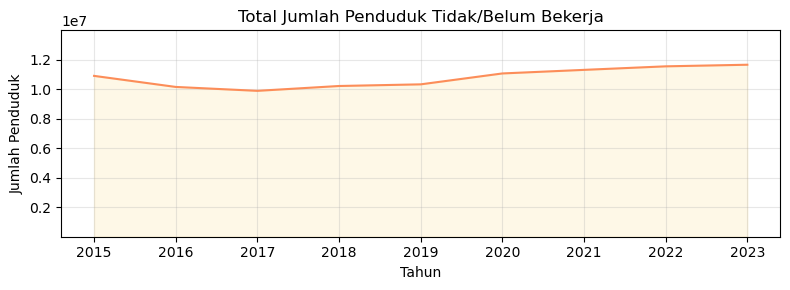

In [25]:
# Mengurutkan data berdasarkan tahun
df_jum_pengangguran_tahunan = df_jum_pengangguran_tahunan.sort_values("tahun")

# Mendefisinikan nilai x dan y
tahun = df_jum_pengangguran_tahunan['tahun']
total = df_jum_pengangguran_tahunan['total_pengangguran']

#Mengatur ukuran gambar
plt.figure(figsize=(8,3))

# Garis utama
sns.lineplot(x=tahun, y=total, color='#fc8d59', linewidth=1.5)

# Area di bawah garis
plt.fill_between(tahun, total, color="#fee08b", alpha=0.2)

#Membuat agar garis berjarak dengan atas tabel
plt.ylim(3, total.max() * 1.2)

# Format Judul dan label 
plt.title("Total Jumlah Penduduk Tidak/Belum Bekerja")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Penduduk")
plt.grid(alpha=0.3)
plt.tight_layout()

#Menyimpan hasil grafik
#plt.savefig(r'...\Jumlah penduduk tidak bekerja 2015sd2019.png')
#--Hilangkan tagar untuk menjalankan program

#Menampilkan hasil plot
plt.show()

In [26]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x= df_jum_pengangguran_tahunan['tahun'].values, # x-axis
    y= df_jum_pengangguran_tahunan['total_pengangguran'].values, # y-axis
    mode='lines', # Connect data points with lines
    name='Line' # Name in the legend
))

# Add and change title style
fig.update_layout(
    title='<b>Jumlah Penduduk Jawa Barat Tidak/Belum Bekerta',
    title_font=dict(size=14),
    title_x=0.04,  # Title aligned with grid
    title_y=0.88,  # Title positioned near the top vertically
    
)
#fig.write_html( r'...\Jumlah penduduk Jawa Barat Tidak Belum Bekerja.html', include_plotlyjs='cdn',  # load Plotly JS dari CDN, bukan disisipkan penuhfull_html=False  # simpan hanya div plot, bukan seluruh HTML page 
 #)

In [27]:
wiraswasta = """
        SELECT 
        tahun,
        SUM(jumlah_penduduk) AS total_wiraswasta
        FROM kel_pekerjaan
        WHERE kelompok_pekerjaan='WIRASWASTA'
        GROUP BY tahun
        ORDER BY tahun DESC"""
df_wiraswasta= pd.read_sql(wiraswasta, engine)

# Tampilkan 5 baris pertama
print(df_wiraswasta.head())

   tahun  total_wiraswasta
0   2023        13965137.0
1   2022        13714642.0
2   2021         4393793.0
3   2020         4372802.0
4   2019         4479523.0


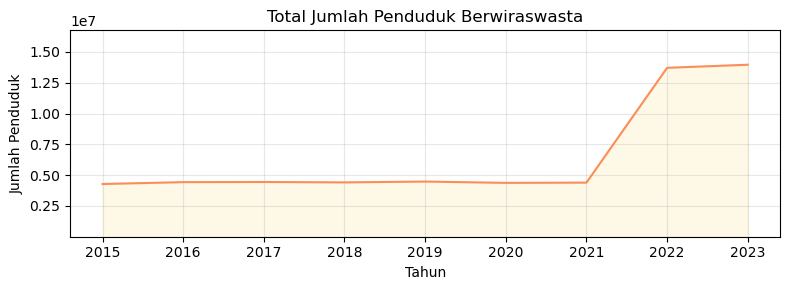

In [28]:
# Mengurutkan data berdasarkan tahun
df_wiraswasta = df_wiraswasta.sort_values("tahun")

# Mendefisinikan nilai x dan y
tahun = df_wiraswasta['tahun']
total = df_wiraswasta['total_wiraswasta']

#Mengatur ukuran gambar
plt.figure(figsize=(8,3))

# Garis utama
sns.lineplot(x=tahun, y=total, color='#fc8d59', linewidth=1.5)

# Area di bawah garis
plt.fill_between(tahun, total, color="#fee08b", alpha=0.2)

#Mmbuat jarak antara line dengan atas tabel
plt.ylim(3, total.max() * 1.2)

#Format judul dan label 
plt.title("Total Jumlah Penduduk Berwiraswasta")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Penduduk")
plt.grid(alpha=0.3)
plt.tight_layout()

#Menimpan gambar
#plt.savefig(r'...\Jumlah penduduk tidak bekerja 2015sd2019.png')
#--Hilangkan tagar untuk menjalankan program

#Menampilkan hasil plot
plt.show()

In [29]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x= df_wiraswasta['tahun'].values, # x-axis
    y= df_wiraswasta['total_wiraswasta'].values, # y-axis
    mode='lines', # Connect data points with lines
    name='Line' # Name in the legend
))

# Add and change title style
fig.update_layout(
    title='<b>Jumlah Penduduk Jawa Barat Berwiraswasta',
    title_font=dict(size=19),
                    #color='#3f3f3f'),
                    #family='Arial'),
    title_x=0.05,  # Title aligned with grid
    title_y=0.88,  # Title positioned near the top vertically
    
)
#fig.write_html( r'...\Penduduk berwiraswasta.html', include_plotlyjs='cdn')

Analisis Jumlah Penduduk Miskin

In [30]:
#Meampilkan 5 baris pertama tabel Jumlah Penduduk Miskin
pd.read_sql("SELECT * FROM jum_pen_miskin LIMIT 5;", engine)

,id,kode_provinsi,nama_provinsi,kode_kabupaten_kota,nama_kabupaten_kota,jumlah_penduduk_miskin,satuan,tahun
0,1,32,JAWA BARAT,3201,KABUPATEN BOGOR,451.3,RIBU JIWA,2002
1,2,32,JAWA BARAT,3202,KABUPATEN SUKABUMI,362.2,RIBU JIWA,2002
2,3,32,JAWA BARAT,3203,KABUPATEN CIANJUR,368.6,RIBU JIWA,2002
3,4,32,JAWA BARAT,3204,KABUPATEN BANDUNG,543.3,RIBU JIWA,2002
4,5,32,JAWA BARAT,3205,KABUPATEN GARUT,323.7,RIBU JIWA,2002


Menganalisis tren jumlah penduduk miskin di Jawa Barat

In [31]:
#Query data agar terlihat jumlah penduduk miskin setiap tahunnya
sum_kemiskinan ="""
    SELECT tahun,
    SUM(jumlah_penduduk_miskin) AS total
    FROM jum_pen_miskin
    GROUP BY tahun
    ORDER BY tahun DESC"""

#Memasuka hasil query ke dalam dataFrame
df_sum_kemiskinan=pd.read_sql(sum_kemiskinan, engine)

#Memunculkan hasil 5 baris teratas
print(df_sum_kemiskinan.head())

   tahun   total
0   2024  3848.7
1   2023  3888.8
2   2022  4071.0
3   2021  4195.7
4   2020  3920.2


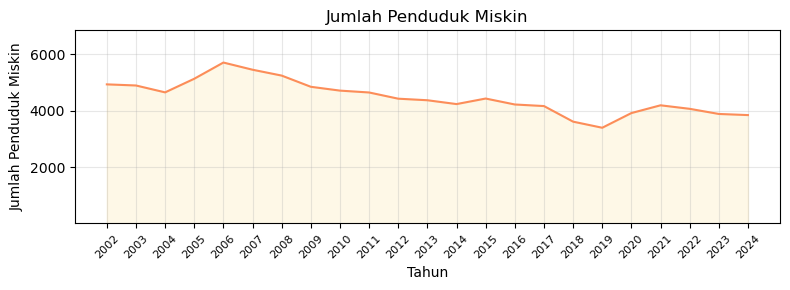

In [32]:
# Mengurutkan data berdasarkan tahun
df_sum_kemiskinan = df_sum_kemiskinan.sort_values("tahun")

# Mendefinisikan x dan y
tahun = df_sum_kemiskinan['tahun']
total = df_sum_kemiskinan['total']

#Mengatur ukuran gambar
plt.figure(figsize=(8,3))

# Garis utama
sns.lineplot(x=tahun, y=total, color='#fc8d59', linewidth=1.5)

# Area di bawah garis
plt.fill_between(tahun, total, color="#fee08b", alpha=0.2)

# Menampilkan semua tahun
plt.xticks(ticks=tahun, labels=tahun)

# Membuat jarak antara line dengan atas tabel
plt.ylim(3, total.max() * 1.2)

# Format judul dan label
plt.title("Jumlah Penduduk Miskin")
plt.xlabel("Tahun")
plt.xticks(rotation=45, fontsize=8) #Rotasi label x agar tidak timpang tindih
plt.ylabel("Jumlah Penduduk Miskin")
plt.grid(alpha=0.3)
plt.tight_layout()

# Menyimpan gambar
# plt.savefig(r'...\Jumlah penduduk miskin 2015sd2019.png')
# --Hilangkan tagar untuk menjalankan program

#Menampilkan hasil plot
plt.show()

In [33]:
# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df_sum_kemiskinan['tahun'], y=df_sum_kemiskinan['total']))

# Set title
fig.update_layout(
    title_text="<b>Jumlah Penduduk Miskin",
    #family='Arial'
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=10,
                     label="10 Tahun Terakhir",
                     step="year",
                     stepmode="todate"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.write_html( r'...\Jumlah penduduk miskin.html', include_plotlyjs='cdn',  # load Plotly JS dari CDN, bukan disisipkan penuhfull_html=False  # simpan hanya div plot, bukan seluruh HTML page 
            )
fig.show()

Menganalisis korelasi jumlah penduduk miskin dengan jumlah kelompok penduduk tidak/belum bekerja dan Jumlah penduduk kelompok wiraswasta

In [34]:
#Query data agar untuk jumlah penduduk miskin pada tahun 2015 sampai dengan 2023
korelasi_kemiskinan ="""
    SELECT tahun,
    SUM(jumlah_penduduk_miskin) AS total_kemiskinan
    FROM jum_pen_miskin
    WHERE tahun BETWEEN '2015' AND '2023'
    GROUP BY tahun
    ORDER BY tahun DESC"""

#Memasuka hasil query ke dalam dataFrame
df_korelasi_kemiskinan=pd.read_sql(korelasi_kemiskinan, engine)

#Memunculkan hasil 5 baris teratas
print(df_korelasi_kemiskinan.head())

   tahun  total_kemiskinan
0   2023            3888.8
1   2022            4071.0
2   2021            4195.7
3   2020            3920.2
4   2019            3399.5


Menggabungkan data jumlah penduduk miskin, kelompok wiraswasta, dan penduduk yang tidak/belum bekerja

In [35]:
#Menggabungkan data
df_korelasi_pen_miskin=pd.merge(df_korelasi_kemiskinan, pd.merge(df_wiraswasta,df_jum_pengangguran_tahunan,on='tahun',how='inner'),on='tahun',how='inner')

#Menampilkan hasil data setelah di gabung
print(df_korelasi_pen_miskin.head())

   tahun  total_kemiskinan  total_wiraswasta  total_pengangguran
0   2023            3888.8        13965137.0          11654686.0
1   2022            4071.0        13714642.0          11545976.0
2   2021            4195.7         4393793.0          11306473.0
3   2020            3920.2         4372802.0          11064005.0
4   2019            3399.5         4479523.0          10325550.0


Menganalisi korelasi menggunakan Metode Kendall

In [36]:
# Mendifinisikan nilai untuk korelasi analisis total kemiskinan terhadap pengngguran
tau_kp, p_value = kendalltau(df_korelasi_pen_miskin['total_kemiskinan'], df_korelasi_pen_miskin['total_pengangguran'])

#Menampilkan hasil kendal dan p-value
print('Jumlah Kemiskinan Vs Jumlah Pengangguran')
print("Nilai Kendall's tau :", tau_kp)
print("P-value:", p_value)


print('-------------------------------------------')
# Mendifinisikan nilai untuk korelasi analisis total kemiskinan terhadap pengngguran
tau_kw, p_value = kendalltau(df_korelasi_pen_miskin['total_wiraswasta'], df_korelasi_pen_miskin['total_kemiskinan'])

#Menampilkan hasil kendal dan p-value
print('Jumlah Kemiskinan Vs Jumlah Wiraswasta')
print("Nilai Kendall's tau:", tau_kw)
print("P-value:", p_value)

Jumlah Kemiskinan Vs Jumlah Pengangguran
Nilai Kendall's tau : -0.1111111111111111
P-value: 0.761414241622575
-------------------------------------------
Jumlah Kemiskinan Vs Jumlah Wiraswasta
Nilai Kendall's tau: -0.3888888888888889
P-value: 0.18018077601410934


Mengetahui kabupaten/kota dengan jumlah penduduk miskin terbanyak

In [37]:
penduduk_miskin_terbanyak="""
                            SELECT nama_kabupaten_kota,
                            SUM(jumlah_penduduk_miskin)
                            FROM jum_pen_miskin
                            WHERE tahun='2019'
                            GROUP BY nama_kabupaten_kota, jumlah_penduduk_miskin
                            ORDER BY jumlah_penduduk_miskin DESC"""

df = pd.read_sql(penduduk_miskin_terbanyak, engine)

# Menampilkan 5 baris pertama
print(df.head())

  nama_kabupaten_kota  SUM(jumlah_penduduk_miskin)
0     KABUPATEN BOGOR                        395.0
1     KABUPATEN GARUT                        235.2
2   KABUPATEN BANDUNG                        223.2
3   KABUPATEN CIREBON                        217.6
4   KABUPATEN CIANJUR                        207.1


Namun, mencari daerah dengan tingkat kemiskinan tertinggi lebih akurat jika dilihat dari persentase atau rasio antara jumlah penduduk miskin terhadap jumlah penduduk di setiap daerah yang ada.

In [38]:
persentase_tingkat_penduduk_miskin="""
                                SELECT m.nama_kabupaten_kota,
                                (m.jumlah_penduduk_miskin / SUM(j.jumlah_penduduk))*10000 AS persen_kemiskinan
                                FROM jum_pen_miskin AS m
                                   INNER JOIN jum_penduduk AS j
                                   ON m.nama_kabupaten_kota=j.nama_kabupaten_kota
                                WHERE j.tahun='2019' AND m.tahun='2019'
                                GROUP BY m.nama_kabupaten_kota,m.jumlah_penduduk_miskin
                                ORDER BY persen_kemiskinan DESC
                                
                                """
df_persentase_tingkat_penduduk_miskin= pd.read_sql(persentase_tingkat_penduduk_miskin, engine)

# Tampilkan 5 baris pertama
print(df_persentase_tingkat_penduduk_miskin.head())   

   nama_kabupaten_kota  persen_kemiskinan
0     KOTA TASIKMALAYA           1.069620
1   KABUPATEN KUNINGAN           1.052144
2  KABUPATEN INDRAMAYU           1.031017
3      KABUPATEN GARUT           1.029584
4    KABUPATEN CIREBON           0.993705


Analisis Jumlah kasus penyakit di Jawa Barat

In [39]:
#Menampilkan 5 baris pertama dari tabel
pd.read_sql("SELECT * FROM kasus_penyakit LIMIT 5;", engine)

,id,kode_provinsi,nama_provinsi,kode_kabupaten_kota,nama_kabupaten_kota,jenis_penyakit,jumlah_kasus,satuan,tahun
0,1,32,JAWA BARAT,3201,KABUPATEN BOGOR,CAMPAK,7,KASUS,2019
1,2,32,JAWA BARAT,3201,KABUPATEN BOGOR,TB TUBERCOLOSIS,7278,KASUS,2019
2,3,32,JAWA BARAT,3201,KABUPATEN BOGOR,PNEUMONIA,7375,KASUS,2019
3,4,32,JAWA BARAT,3201,KABUPATEN BOGOR,KUSTA,340,KASUS,2019
4,5,32,JAWA BARAT,3201,KABUPATEN BOGOR,TETANUS,1,KASUS,2019


Melihat jumlah kasus penyakit setiap tahunnya

In [40]:
#Query data untuk melihat jumla kasus penyakit setiap tahunnya
sum_penyakit="""
    SELECT tahun,
    SUM(jumlah_kasus) AS total
    FROM kasus_penyakit
    GROUP BY tahun
    ORDER BY tahun"""

#Memasukan hasil query ke dalam dataFrame
df_sum_penyakit= pd.read_sql(sum_penyakit, engine)

# Menampilkan 5 baris pertama
print(df_sum_penyakit.head())

   tahun     total
0   2019  979894.0


Menganalisis jumlah jenis penyakit terbanyak

In [41]:
#Membuat query data untuk jumlah kasus perjenis penyakit (Diurutkan dari kasus terbanyak)
jenis_penyakit= """ 
                    SELECT jenis_penyakit,
                        SUM(jumlah_kasus) AS jumlah_kasus
                    FROM kasus_penyakit
                    GROUP BY
                        jenis_penyakit
                    ORDER BY jumlah_kasus DESC
                   """
#Memasukan hasil query ke dalam dataFrame
df_jenis_penyakit= pd.read_sql(jenis_penyakit, engine)

# Tampilkan 5 baris pertama
print(df_jenis_penyakit.head())

    jenis_penyakit  jumlah_kasus
0            DIARE      794328.0
1        PNEUMONIA      134530.0
2  TB TUBERCOLOSIS       33883.0
3              DBD       12492.0
4            KUSTA        2042.0


Menganalisis daerah dengan catatan kasus penyakit terbanyak

In [42]:
#Query data untuk melihat jumlah kota/kaupaten dengan jumlah kasus penyakit tertinggi
kasus_penyakit_perdaerah= """ 
                    SELECT nama_kabupaten_kota, jenis_penyakit,
                        SUM(jumlah_kasus) AS jumlah_kasus
                    FROM kasus_penyakit
                    GROUP BY
                        nama_kabupaten_kota, jenis_penyakit
                    ORDER BY jumlah_kasus DESC
                   """

#Memasukan hasil query ke dataFrame
df_kasus_penyakit_perdaerah= pd.read_sql(kasus_penyakit_perdaerah, engine)

# Menampilkan 5 baris pertama
print(df_kasus_penyakit_perdaerah.head())

  nama_kabupaten_kota jenis_penyakit  jumlah_kasus
0     KABUPATEN BOGOR          DIARE       83940.0
1   KABUPATEN CIANJUR          DIARE       62517.0
2     KABUPATEN GARUT          DIARE       60559.0
3        KOTA BANDUNG          DIARE       59511.0
4  KABUPATEN KARAWANG          DIARE       57682.0


Menganalisis jumlah jenis penyakit perdaerah

In [43]:
#Membuat tabel pivot dari dataFrame yang sudah di buat 
pivot_jenis_penyakit = df_kasus_penyakit.pivot_table(
    index='nama_kabupaten_kota',   # Ini jadi sumbu Y (baris)
    columns='jenis_penyakit',              # Ini jadi sumbu X (kolom)
    values='jumlah_kasus',               # Nilai yang ditampilkan
    aggfunc='sum'                 # Kalau ada duplikat, dijumlahkan
)

# Mengubah NaN menjadi o
pivot_jenis_penyakit=pivot_jenis_penyakit.fillna(0)

#Menampilkan hasil pivot
print(pivot_jenis_penyakit)

jenis_penyakit           AIDS   CAMPAK     DBD    DIARE  KUSTA  MALARIA  \
nama_kabupaten_kota                                                       
KABUPATEN BANDUNG          0.0     0.0  1774.0  57468.0    5.0      9.0   
KABUPATEN BANDUNG BARAT   24.0    17.0   419.0  14494.0    5.0      0.0   
KABUPATEN BEKASI           0.0     0.0   181.0  29238.0  207.0      1.0   
KABUPATEN BOGOR           16.0    16.0   741.0  83940.0  340.0      0.0   
KABUPATEN CIAMIS           0.0     2.0    29.0  27369.0   13.0      8.0   
KABUPATEN CIANJUR          0.0   153.0   113.0  62517.0   26.0      0.0   
KABUPATEN CIREBON          3.0    92.0   215.0  45757.0  228.0     18.0   
KABUPATEN GARUT           39.0     1.0   331.0  60559.0   18.0      0.0   
KABUPATEN INDRAMAYU      329.0   158.0   911.0      0.0  211.0      6.0   
KABUPATEN KARAWANG         0.0     0.0    60.0  57682.0  333.0      6.0   
KABUPATEN KUNINGAN        49.0    18.0   352.0  24100.0   80.0      3.0   
KABUPATEN MAJALENGKA     

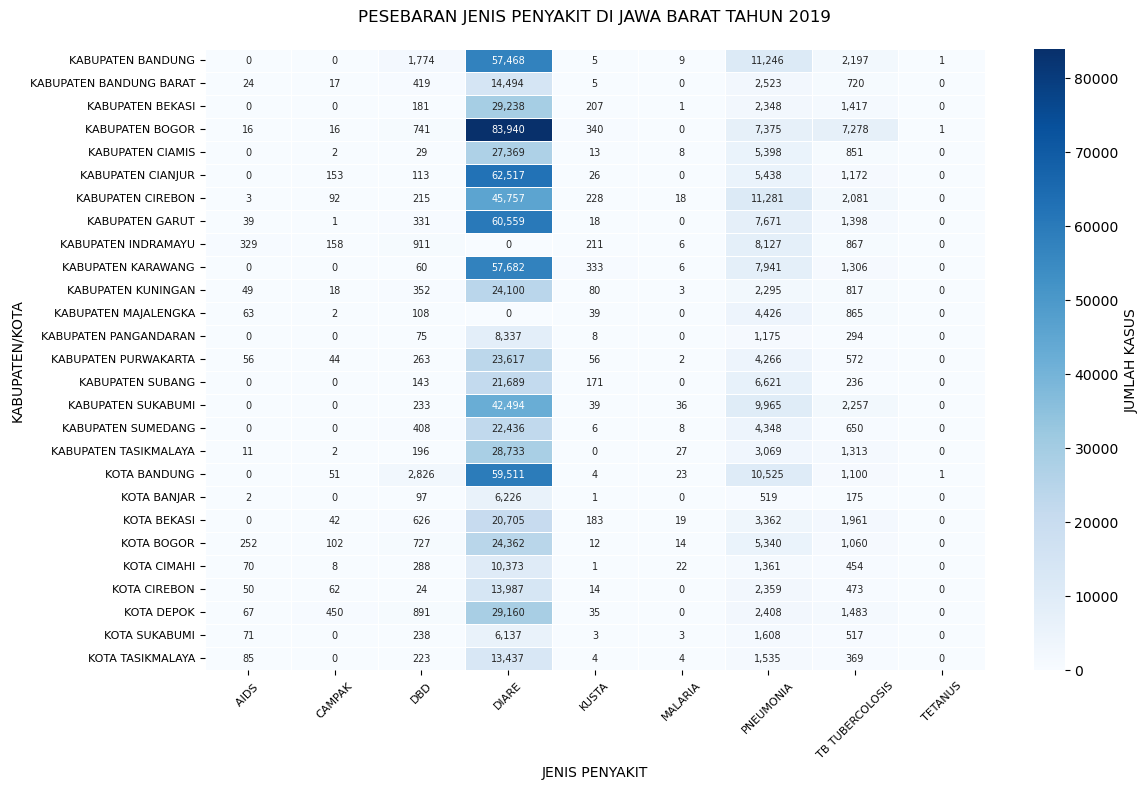

In [44]:
#Heatmap menggunakan library seaborn dan matplotlib
#Mengatur besar gambar yang akan di buat
plt.figure(figsize=(12, 8))

#Mmebuat heatmap
sns.heatmap(pivot_jenis_penyakit, #Mengambil data dari tabel pivot 
            annot=True, #Menampilkan angka pada data
            fmt=",.0f", #Mengatur format koma dan titik angka
            cmap="Blues", #Format set warna
            linewidths=.5, #Format besar line
            cbar_kws={'label': 'JUMLAH KASUS'}, #Title bar warna
            annot_kws={"size": 7}) #size angka pada angka di heatmap


#Format label dan judul
plt.title("PESEBARAN JENIS PENYAKIT DI JAWA BARAT TAHUN 2019", pad=20)
plt.xlabel("JENIS PENYAKIT")
plt.ylabel("KABUPATEN/KOTA")
plt.xticks(rotation=45, fontsize=8) #Rotasi label x agar tidak timpang tindih
plt.yticks(rotation=0, fontsize=8) #Rotasi label y dan fontsize
plt.tight_layout()

#Menyimpan gambar
plt.savefig(
    r'...\Sebaran Jenis Penyakit.png',
    dpi=300, bbox_inches='tight'
)
#--Hilangkan tagar untuk menjalankan program

#Menampilkan hasil plot
plt.show()


Analisis kasus kematian di Jawa Barat

In [45]:
# Menampilkan 5 baris pertama tabel
pd.read_sql("SELECT * FROM jum_kematian LIMIT 5;", engine)

,id,kode_provinsi,nama_provinsi,kode_kabupaten_kota,nama_kabupaten_kota,jenis_kematian,penyebab_kematian,jumlah_kematian,satuan,tahun
0,1,32,JAWA BARAT,3201,KABUPATEN BOGOR,KEMATIAN BALITA,CAMPAK,0,JIWA,2017
1,2,32,JAWA BARAT,3201,KABUPATEN BOGOR,KEMATIAN BALITA,DEMAM,0,JIWA,2017
2,3,32,JAWA BARAT,3201,KABUPATEN BOGOR,KEMATIAN BALITA,DIARE,0,JIWA,2017
3,4,32,JAWA BARAT,3201,KABUPATEN BOGOR,KEMATIAN BALITA,DIFTERI,0,JIWA,2017
4,5,32,JAWA BARAT,3201,KABUPATEN BOGOR,KEMATIAN BALITA,LAIN-LAIN,7,JIWA,2017


In [46]:
#Query data untuk melihat jumlah kasus kematian pertahun
jumlah_kematian_pertaun="""
    SELECT 
        tahun,
        SUM(jumlah_kematian) AS total_kasus
    FROM jum_kematian
    GROUP BY tahun
    ORDER BY tahun"""

# Memasukan hasil query ke dalam dataFrame
df_jumlah_kematian_pertaun = pd.read_sql(jumlah_kematian_pertaun, engine)

# Menampilkan 5 baris pertama
print(df_jumlah_kematian_pertaun.head())

   tahun  total_kasus
0   2017       4193.0
1   2018       4007.0
2   2019       3743.0


Menganalisis jenis dan penyebab kematian terbanyak pada tahun terakhir tercatatnya jumlah kematian di Jawa Barat menggunakan tabel heatmap. 

In [47]:
#Query data untuk mengetahui jumlah dari masing-masing jenis dan penyebab kematian pada tahun terakhir yang tercatat
kasus_kematian= """
                        SELECT jenis_kematian,penyebab_kematian,
                        SUM(jumlah_kematian) AS kasus_kematian
                        FROM jum_kematian
                        WHERE tahun='2019'
                        GROUP BY jenis_kematian,penyebab_kematian
                        ORDER BY kasus_kematian DESC"""

# Memasukan hasil query ke dalam dataFrame
df_kasus_kematian= pd.read_sql(kasus_kematian, engine)

# Tampilkan 5 baris pertama
print(df_kasus_kematian.head())

      jenis_kematian penyebab_kematian  kasus_kematian
0         LAHIR MATI              BBLR           948.0
1         LAHIR MATI          ASFIKSIA           650.0
2         LAHIR MATI         LAIN-LAIN           407.0
3  KEMATIAN POST-NEO         LAIN-LAIN           316.0
4         LAHIR MATI          KELAINAN           273.0


Membuat tabel pivot untuk membuat tabel heatmap

In [48]:
#Membuat tabel pivot dari dataFrame yang sudah di buat 
pivot_kasus_kematian = df_kasus_kematian.pivot_table(
    index='penyebab_kematian',   # Ini jadi sumbu Y (baris)
    columns='jenis_kematian',              # Ini jadi sumbu X (kolom)
    values='kasus_kematian',               # Nilai yang ditampilkan
    aggfunc='sum'                 # Kalau ada duplikat, dijumlahkan
)

# Mengubah NaN menjadi 0
pivot_kasus_kematian=pivot_kasus_kematian.fillna(0)

#Menampilkan hasil pivot
print(pivot_kasus_kematian)

jenis_kematian      KEMATIAN BALITA  KEMATIAN IBU  KEMATIAN POST-NEO  \
penyebab_kematian                                                      
ASFIKSIA                        0.0           0.0                0.0   
BBLR                            0.0           0.0                0.0   
CAMPAK                          0.0           0.0                0.0   
DEMAM                          29.0           0.0                0.0   
DIARE                          17.0           0.0               65.0   
DIFTERI                         0.0           0.0                0.0   
GANGGUAN DARAH                  0.0          67.0                0.0   
GANGGUAN METABOLIK              0.0          12.0                0.0   
HIPERTENSI                      0.0         220.0                0.0   
INFEKSI                         0.0          23.0                0.0   
KELAINAN                        0.0           0.0                0.0   
KELAINAN SARAF                  0.0           0.0               

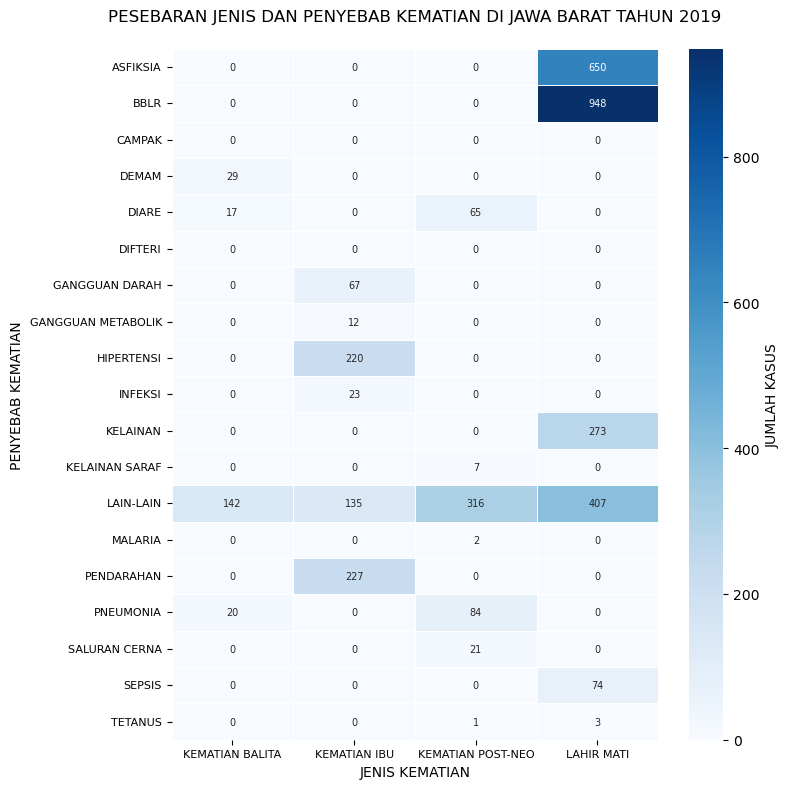

In [49]:
#Heatmap menggunakan library seaborn dan matplotlib
#Mengatur besar gambar yang akan di buat
plt.figure(figsize=(8, 8))

#Mmebuat heatmap
sns.heatmap(pivot_kasus_kematian, #Mengambil data dari tabel pivot 
            annot=True, #Menampilkan angka pada data
            fmt=",.0f", #Mengatur format koma dan titik angka
            cmap="Blues", #Format set warna
            linewidths=.5, #Format besar line
            cbar_kws={'label': 'JUMLAH KASUS'}, #Title bar warna
            annot_kws={"size": 7}) #size angka pada angka di heatmap


#Format label dan judul
plt.title("PESEBARAN JENIS DAN PENYEBAB KEMATIAN DI JAWA BARAT TAHUN 2019", pad=20)
plt.xlabel("JENIS KEMATIAN")
plt.ylabel("PENYEBAB KEMATIAN")
plt.xticks(fontsize=8) #Rotasi label x agar tidak timpang tindih
plt.yticks(rotation=0, fontsize=8) #Rotasi label y dan fontsize
plt.tight_layout()

#Menyimpan gambar
plt.savefig(
    r'...\Sebaran Jenis dan penyebab kematian.png',
    dpi=300, bbox_inches='tight'
)
#--Hilangkan tagar untuk menjalankan program

#Menampilkan hasil plot
plt.show()

Interactive chart

In [50]:
# Kembalikan ke format long agar bisa digunakan di treemap
df_long = pivot_kasus_kematian.reset_index().melt(
    id_vars='penyebab_kematian',
    var_name='jenis_kematian',
    value_name='kasus_kematian'
)

# Filter data dengan jumlah kasus > 0 (hindari ZeroDivisionError)
df_long = df_long[df_long['kasus_kematian'] > 0]


In [51]:
import plotly.express as px

fig = px.treemap(
    df_long, 
    path=['jenis_kematian', 'penyebab_kematian'], 
    values='kasus_kematian',
    color='kasus_kematian',  # Gunakan nilai untuk pewarnaan
    color_continuous_scale='blues',  # Skema warna YlOrRd
    title='<b>JENIS DAN PENYEBAB KEMATIAN DI JAWA BARAT TAHUN 2019',
    
)
fig.update_coloraxes(colorbar_title='JUMLAH KEMATIAN')
fig.update_layout(
    margin=dict(t=60, l=10, r=10, b=10),
    title_x=0.5  # Ini untuk membuat judul di tengah
)
fig.write_html( r'...\Jenis dan Penyebab kematian.html', include_plotlyjs='cdn',  # load Plotly JS dari CDN, bukan disisipkan penuhfull_html=False  # simpan hanya div plot, bukan seluruh HTML page 
 )

fig.show()


Menganalisis pesebaran jenis kematian di Jawa Barat pada tahun 2019

In [52]:
# Query data untuk meliat jumlah kasus kematian berdasarkan jenis kematiannya
pesebaran_jenis_kematian="""
                        SELECT jenis_kematian,
                        SUM(jumlah_kematian) AS kasus_kematian
                        FROM jum_kematian
                        WHERE tahun='2019'
                        GROUP BY jenis_kematian
                        ORDER BY kasus_kematian DESC"""

# Memasukan hasil ke dalam dataFrame
df_pesebaran_jenis_kematian= pd.read_sql(pesebaran_jenis_kematian, engine)

# Menampilkan 5 baris pertama
print(df_pesebaran_jenis_kematian.head())

      jenis_kematian  kasus_kematian
0         LAHIR MATI          2355.0
1       KEMATIAN IBU           684.0
2  KEMATIAN POST-NEO           496.0
3    KEMATIAN BALITA           208.0


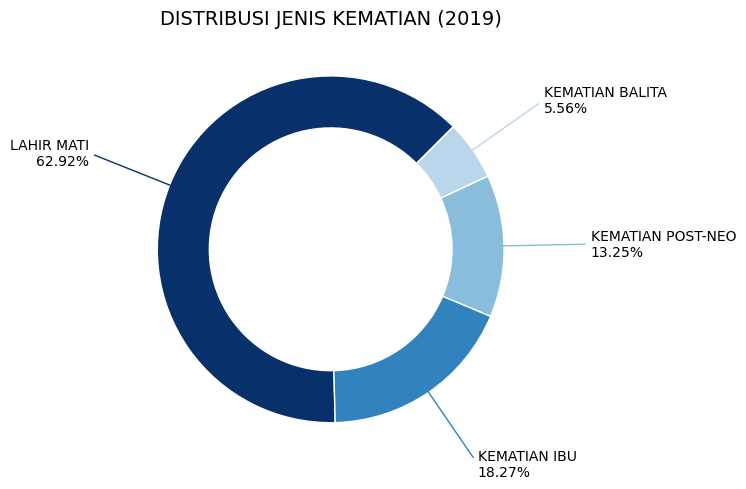

In [53]:
# Data
labels = df_pesebaran_jenis_kematian['jenis_kematian']
sizes = df_pesebaran_jenis_kematian['kasus_kematian']
colors = ['#08306b', '#3282be', '#88bedc', '#bad6eb']

# Total keseluruhan
total = sum(sizes)

# Plot donat
fig, ax = plt.subplots(figsize=(7, 5))
wedges, texts = ax.pie(

    sizes,
    labels=None,
    colors=colors,
    startangle=45,
    pctdistance=0.7,
    wedgeprops=dict(width=0.3, edgecolor='white'),
   labeldistance=10

)

# Menambahkan garis + label dua baris (label dan persentase)
for i, p in enumerate(wedges):
    ang = (p.theta2 + p.theta1) / 2.
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))

    # Posisi dan arah teks
    horizontalalignment = 'left' if x >= 0 else 'right'
    connectionstyle = f"angle,angleA=0,angleB={ang}"

    # Hitung persentase
    percent = sizes.iloc[i] / total * 100
    label_text = f"{labels.iloc[i]}\n{percent:.2f}%"

    ax.annotate(
        label_text,
        xy=(x*0.9, y*0.9),         # ujung garis ke donat
        xytext=(x*1.5, y*1.5),     # posisi teks
        ha=horizontalalignment,
        va='center',
        fontsize=10,
        arrowprops=dict(
            arrowstyle="-", 
            connectionstyle=connectionstyle, 
            color=colors[i]
        )
    )

# Menambah lingkaran tengah agar jadi donat
centre_circle = plt.Circle((0, 0), 0.15, fc='white')
ax.add_artist(centre_circle)

# Judul
ax.set_title("DISTRIBUSI JENIS KEMATIAN (2019)", fontsize=14)
plt.tight_layout()

plt.savefig(
    r'...\Distribusi Jenis kematian.png',
    dpi=300, bbox_inches='tight'
)
# Menampilkan hasil plot
plt.show()

Mengetahui kabupaten/kota dengan kasus kematian terbanyak beserta jenis dan penyebabnya.

In [54]:
kasus_kematian_terbanyak= """
                        SELECT nama_kabupaten_kota, jenis_kematian, penyebab_kematian,
                        SUM(jumlah_kematian) AS kasus_kematian
                        FROM jum_kematian
                        WHERE tahun='2019'
                        GROUP BY nama_kabupaten_kota, jenis_kematian,penyebab_kematian
                        ORDER BY kasus_kematian DESC"""

df_kasus_kematian_terbanyak= pd.read_sql(kasus_kematian_terbanyak, engine)

print(df_kasus_kematian_terbanyak.head())

       nama_kabupaten_kota jenis_kematian penyebab_kematian  kasus_kematian
0      KABUPATEN INDRAMAYU     LAHIR MATI              BBLR           115.0
1          KABUPATEN GARUT     LAHIR MATI              BBLR           106.0
2        KABUPATEN BANDUNG     LAHIR MATI         LAIN-LAIN            97.0
3  KABUPATEN BANDUNG BARAT     LAHIR MATI              BBLR            79.0
4       KABUPATEN SUKABUMI     LAHIR MATI              BBLR            70.0


In [55]:
daerah_kasus_terbanyak="""
         SELECT nama_kabupaten_kota, 
            SUM(jumlah_kematian) AS kasus_kematian
        FROM jum_kematian
        WHERE tahun='2019'
        GROUP BY nama_kabupaten_kota
        ORDER BY kasus_kematian DESC"""

df_daerah_kasus_terbanyak= pd.read_sql(daerah_kasus_terbanyak, engine)

print(df_daerah_kasus_terbanyak.head())

     nama_kabupaten_kota  kasus_kematian
0        KABUPATEN GARUT           294.0
1    KABUPATEN INDRAMAYU           294.0
2     KABUPATEN SUKABUMI           272.0
3      KABUPATEN BANDUNG           268.0
4  KABUPATEN TASIKMALAYA           220.0


Menganalisis pengaruh jumlah penduduk dengan jumlah kematian di setiap daerah.

In [56]:
penduduk_2019 = """
        SELECT 
        nama_kabupaten_kota,
        SUM(jumlah_penduduk) AS total_penduduk
        FROM jum_penduduk
        WHERE tahun='2019'
        GROUP BY nama_kabupaten_kota
        ORDER BY nama_kabupaten_kota"""

#Memasukan hasil query ke dalam dataFrame
df_penduduk_2019= pd.read_sql(penduduk_2019, engine)

# Menampilkan 5 baris pertama
print(df_penduduk_2019.head())

       nama_kabupaten_kota  total_penduduk
0        KABUPATEN BANDUNG       3561679.0
1  KABUPATEN BANDUNG BARAT       1667724.0
2         KABUPATEN BEKASI       2674861.0
3          KABUPATEN BOGOR       4715924.0
4         KABUPATEN CIAMIS       1253483.0


In [57]:
korelasi_jumpend_kaskem=pd.merge(df_penduduk_2019,df_daerah_kasus_terbanyak, on='nama_kabupaten_kota',how='inner')
print(korelasi_jumpend_kaskem.head())

       nama_kabupaten_kota  total_penduduk  kasus_kematian
0        KABUPATEN BANDUNG       3561679.0           268.0
1  KABUPATEN BANDUNG BARAT       1667724.0           192.0
2         KABUPATEN BEKASI       2674861.0            57.0
3          KABUPATEN BOGOR       4715924.0           182.0
4         KABUPATEN CIAMIS       1253483.0           128.0


In [58]:
# Mendifinisikan nilai untuk korelasi analisis total kemiskinan terhadap pengngguran
tau, p_value = kendalltau(korelasi_jumpend_kaskem['total_penduduk'], korelasi_jumpend_kaskem['kasus_kematian'])

#Menampilkan hasil kendal dan p-value
print('Jumlah Penduduk Vs Jumlah Kasus Kematian Tahun 2019')
print("Nilai Kendall's tau :", tau)
print("P-value:", p_value)

Jumlah Penduduk Vs Jumlah Kasus Kematian Tahun 2019
Nilai Kendall's tau : 0.50784645111295
P-value: 0.00020598861803961227


Karena terdapat korelasi antara jumlah penduduk dengan jumlah kasus kematian, maka untuk mencari daerah dengan tingkat kasus kematian tertinggi menggunakan presentase antara jumlah kasus kematian dengan jumlah penduduk.

In [59]:
persentase_kematian_tertinggi= """
                    WITH p AS(
                        SELECT nama_kabupaten_kota, 
                        SUM(jumlah_kematian) AS kasus_kematian
                        FROM jum_kematian
                        WHERE tahun='2019'
                        GROUP BY nama_kabupaten_kota
                        )
                    SELECT 
                        p.nama_kabupaten_kota, 
                        (p.kasus_kematian/SUM(j.jumlah_penduduk))*100 AS rasio_kematian
                    FROM jum_penduduk AS j
                        INNER JOIN p
                        ON p.nama_kabupaten_kota=j.nama_kabupaten_kota
                    WHERE j.tahun='2019'
                        GROUP BY p.nama_kabupaten_kota
                    ORDER BY rasio_kematian DESC
                        """
df_persentase_kematian_tertinggi= pd.read_sql(persentase_kematian_tertinggi, engine)

# Tampilkan 5 baris pertama
print(df_persentase_kematian_tertinggi.head())

   nama_kabupaten_kota  rasio_kematian
0          KOTA BANJAR          0.0214
1  KABUPATEN INDRAMAYU          0.0158
2          KOTA CIMAHI          0.0143
3   KABUPATEN SUMEDANG          0.0136
4        KOTA SUKABUMI          0.0135


Analisis tingkat kasus kematian terhadap fasilitas kesehatan di Jawa Barat. 

In [60]:
pd.read_sql("SELECT * FROM jum_fasilitas LIMIT 5;", engine)

,id,kode_provinsi,nama_provinsi,kode_kabupaten_kota,nama_kabupaten_kota,jenis_faskes,jumlah_faskes,satuan,tahun
0,1,32,JAWA BARAT,3201,KABUPATEN BOGOR,RUMAH SAKIT UMUM,9,UNIT,2018
1,2,32,JAWA BARAT,3201,KABUPATEN BOGOR,RUMAH SAKIT KHUSUS,0,UNIT,2018
2,3,32,JAWA BARAT,3201,KABUPATEN BOGOR,RUMAH SAKIT BERSALIN,0,UNIT,2018
3,4,32,JAWA BARAT,3201,KABUPATEN BOGOR,PUSKESMAS,62,UNIT,2018
4,5,32,JAWA BARAT,3201,KABUPATEN BOGOR,POSYANDU,4927,UNIT,2018


In [61]:
jumlah_faskes_pertahun="""
                        SELECT tahun,
                        SUM(jumlah_faskes) AS jum_faskes
                        FROM jum_fasilitas
                        GROUP BY tahun
                        ORDER BY tahun"""
df_jumlah_faskes_pertahun= pd.read_sql(jumlah_faskes_pertahun, engine)

# Tampilkan 5 baris pertama
print(df_jumlah_faskes_pertahun.head())                                

   tahun  jum_faskes
0   2018     54220.0
1   2019      1450.0
2   2020     53937.0
3   2021     53474.0
4   2022     54111.0


>Karena terdapat ketidakwajaran pada data tahun 2019 dan ketersediaan dataset Jumlah kasus kematian, maka untuk menganalisis kematian terhadap jumlah fasilitas kesehatan menggunakan data pada tahun 2018.

Dilakukan query data jumlah kasus kematian pada tahun 2018. Mengingat terdapat hubungan antara jumlah penduduk dan jumlah kasus kematian, maka untuk menganalisis korelasi antara jumlah fasilitas kesehatan dan kasus kematian digunakan rasio jumlah kematian terhadap jumlah penduduk sebagai indikator yang lebih representatif.

In [62]:
kasus_kematian_2018= """
                    WITH p AS(
                        SELECT nama_kabupaten_kota, 
                        SUM(jumlah_kematian) AS kasus_kematian
                        FROM jum_kematian
                        WHERE tahun='2018' 
                        GROUP BY nama_kabupaten_kota
                        )
                    SELECT 
                        p.nama_kabupaten_kota, 
                        (p.kasus_kematian/SUM(j.jumlah_penduduk))*100 AS rasio_kematian
                    FROM jum_penduduk AS j
                        INNER JOIN p
                        ON p.nama_kabupaten_kota=j.nama_kabupaten_kota
                    WHERE j.tahun='2018'
                        GROUP BY p.nama_kabupaten_kota
                    ORDER BY rasio_kematian DESC
                        """
df_kasus_kematian_2018= pd.read_sql(kasus_kematian_2018, engine)

# Tampilkan 5 baris pertama
print(df_kasus_kematian_2018.head())

     nama_kabupaten_kota  rasio_kematian
0            KOTA BANJAR          0.0230
1  KABUPATEN TASIKMALAYA          0.0172
2    KABUPATEN INDRAMAYU          0.0170
3     KABUPATEN SUMEDANG          0.0164
4       KOTA TASIKMALAYA          0.0150


Query data jumlah fasilitas kesehatan pada tahun 2018

In [63]:
jum_faskes_2018="""
         SELECT nama_kabupaten_kota, 
            SUM(jumlah_faskes) AS jumlah_faskes
        FROM jum_fasilitas
        WHERE tahun='2018'
        GROUP BY nama_kabupaten_kota
        ORDER BY jumlah_faskes DESC"""

df_jum_faskes_2018= pd.read_sql(jum_faskes_2018, engine)

print(df_jum_faskes_2018.head())

  nama_kabupaten_kota  jumlah_faskes
0     KABUPATEN BOGOR         4998.0
1   KABUPATEN BANDUNG         4420.0
2     KABUPATEN GARUT         4145.0
3  KABUPATEN SUKABUMI         3590.0
4   KABUPATEN CIANJUR         2958.0


In [64]:
df_faskes_kematian=pd.merge(df_jum_faskes_2018,df_kasus_kematian_2018,on='nama_kabupaten_kota',how='inner')
print(df_faskes_kematian.head())

  nama_kabupaten_kota  jumlah_faskes  rasio_kematian
0     KABUPATEN BOGOR         4998.0          0.0037
1   KABUPATEN BANDUNG         4420.0          0.0070
2     KABUPATEN GARUT         4145.0          0.0147
3  KABUPATEN SUKABUMI         3590.0          0.0140
4   KABUPATEN CIANJUR         2958.0          0.0049


Analisis korelasi tingkat kematian dengan jumlah fasilitas kesehatan menggunakan Kendall Tau

In [65]:
tau, p_value = kendalltau(df_faskes_kematian['jumlah_faskes'], df_faskes_kematian['rasio_kematian'])

print("Nilai Kendall's tau:", tau)
print("P-value:", p_value)

Nilai Kendall's tau: -0.14265349750363765
P-value: 0.2971465303484704


Menganalisis jumlah fasilitas kesehatan terhadap jumlah penduduk.

In [66]:
# Mengambil data jumlah fasilitas kesehatan pada tahun 2024
jum_faskes_2024="""
         SELECT nama_kabupaten_kota, 
            SUM(jumlah_faskes) AS jumlah_faskes
        FROM jum_fasilitas
        WHERE tahun='2024'
        GROUP BY nama_kabupaten_kota
        ORDER BY jumlah_faskes DESC"""

df_jum_faskes_2024= pd.read_sql(jum_faskes_2024, engine)

print(df_jum_faskes_2024.head())

  nama_kabupaten_kota  jumlah_faskes
0     KABUPATEN BOGOR         5284.0
1     KABUPATEN GARUT         4455.0
2   KABUPATEN BANDUNG         4436.0
3  KABUPATEN SUKABUMI         3635.0
4    KABUPATEN BEKASI         3058.0


Mengambil data jumlah penduduk pada tahun 20214

In [67]:
jumpen_2024="""
         SELECT nama_kabupaten_kota, 
            SUM(jumlah_penduduk) AS jumlah_penduduk
        FROM jum_penduduk
        WHERE tahun='2024'
        GROUP BY nama_kabupaten_kota
        ORDER BY nama_kabupaten_kota DESC"""

df_jumpen_2024= pd.read_sql(jumpen_2024, engine)

print(df_jumpen_2024.head())

  nama_kabupaten_kota  jumlah_penduduk
0    KOTA TASIKMALAYA         770839.0
1       KOTA SUKABUMI         370096.0
2          KOTA DEPOK        2010912.0
3        KOTA CIREBON         356629.0
4         KOTA CIMAHI         581994.0


In [68]:
df_faskes_penduduk=pd.merge(df_jum_faskes_2024,df_jumpen_2024,on='nama_kabupaten_kota',how='inner')
print(df_faskes_penduduk.head())

  nama_kabupaten_kota  jumlah_faskes  jumlah_penduduk
0     KABUPATEN BOGOR         5284.0        5809790.0
1     KABUPATEN GARUT         4455.0        2851877.0
2   KABUPATEN BANDUNG         4436.0        3839721.0
3  KABUPATEN SUKABUMI         3635.0        2868943.0
4    KABUPATEN BEKASI         3058.0        3387601.0


In [69]:
tau, p_value = kendalltau(df_faskes_penduduk['jumlah_faskes'], df_faskes_penduduk['jumlah_penduduk'])

print("Nilai Kendall's tau:", tau)
print("P-value:", p_value)

Nilai Kendall's tau: 0.8233618233618234
P-value: 1.1083958044590423e-12
